In [19]:
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
import scipy.optimize as opt
import ot

In [56]:
# OT Framework

class LOT(object):
    
    # parameters :
        # x_ref : (num_ref,dim_ref) reference points
        # x_tar : (num_tar,dim_tar) target points
        # p_ref : (num_ref,) reference weights
        # p_tar : (num_tar,) target weights
        # sinkhorn : bool whether to use sinkhorn
        # beta : float regularization parameter
        # max_num_iter : int maximum number of iterations
        # metric : str method to use to compute costs, e.g.
            # "square_euclidean" , "euclidean" , "discrete"
    
    def __init__(self, x_ref, x_tar, p_ref=None, p_tar=None, sinkhorn = False,  beta = 0.01, max_num_iter = 100000, metric = "square_euclidean"):
        self.np_attributes = ['x_ref','x_tar','p_ref','p_tar', 'cost','plan','ot_map']
        self.dict_attributes = ['sinkhorn','beta','metric']

        self.x_ref = x_ref
        self.x_tar = x_tar

        self.num_ref, self.dim_ref = x_ref.shape
        self.num_tar, self.dim_tar = x_tar.shape
        if p_ref is None:
            self.p_ref = np.ones((self.num_ref,))/self.num_ref
        else:
            self.p_ref = p_ref
        if p_tar is None:
            self.p_tar = np.ones((self.num_tar,))/self.num_tar
        else:
            self.p_tar = p_tar
        
        self.sinkhorn = sinkhorn
        self.beta = beta
        self.max_num_iter = max_num_iter
        self.metric = metric
        self.cost = None
        self.plan = None
        self.ot_map = None


    


    def calc_ot_map(self,):
        
        # returns :
            # ot_map : (num_ref, num_tar) barycentric projection OT map

        self.cost = compute_cost(self.x_ref, self.x_tar, self.metric)
        #print(self.cost)
        self.plan = create_plan(self.p_ref, self.p_tar, self.cost, self.sinkhorn, self.beta, self.max_num_iter)
        #print(self.plan)
        self.ot_map = compute_barycentric_map(self.plan, self.x_tar)
        return self.ot_map
    
    

    

    def save(self, dir_path = None, obj_name = None):

        # returns :
            # obj_path : str with path to object directory
        
        # parameters :
            # dir_path : str with path to base directory
            # obj_name : name of object (will be name of directory with saved files)
        
        if dir_path is None:
            dir_path = os.getcwd()
        if obj_name is None:
            obj_name = "Unnamed_" + hex(np.random.randint(0,16**4))[2:]
        
        obj_path = create_directory(dir_path, obj_name)
        json_filepath = os.path.join(obj_path, "dict_attributes")
        npsv_filepath = os.path.join(obj_path, "npsv_attributes.npz")
        
        dictionary = {
            'sinkhorn': self.sinkhorn,
            'beta': self.beta,
            'metric': self.metric
        }

        with open(json_filepath, 'w') as fp:
            json.dump(dictionary, fp)
        
        np.savez(npsv_filepath,
            x_ref = self.x_ref, 
            x_tar = self.x_tar,
            p_ref = self.p_ref,
            p_tar = self.p_tar,
            cost = self.cost,
            plan = self.plan,
            ot_map = self.ot_map
        )
        
        return obj_path

def load_lot_object(obj_path):

    # returns :
        # obj : LOT object with loaded attributes

    # parameters :
        # obj_path : str with path to object directory

    dict_filepath = os.path.join(obj_path, "dict_attributes")
    npsv_filepath = os.path.join(obj_path, "npsv_attributes.npz")

    with open(dict_filepath, 'r') as fp:
        dict_file = json.load(fp)
    npsv_file = np.load(npsv_filepath)

    sinkhorn = dict_file['sinkhorn']
    beta = dict_file['beta']
    metric = dict_file['metric']

    x_ref = npsv_file['x_ref']
    x_tar = npsv_file['x_tar']
    p_ref = npsv_file['p_ref']
    p_tar = npsv_file['p_tar']
    cost = npsv_file['cost']
    plan = npsv_file['plan']
    ot_map = npsv_file['ot_map']

    obj = LOT(x_ref, x_tar, p_ref, p_tar, sinkhorn, beta, metric)
    obj.cost = cost
    obj.plan = plan
    obj.ot_map = ot_map

    return obj

def compute_cost(x_ref, x_tar = None, metric = "square_euclidean"):

    # returns :
        # C : (num_ref,num_tar) ground cost matrix

    # parameters:
        # x_ref : (num_ref,dim_ref) num_ref reference points of dimension dim_ref
        # x_tar : (num_tar,dim_tar) num_tar target points of dimension dim_tar
            # if None then x_tar = x_ref
        # metric : str method to use to compute costs, e.g.
            # "square_euclidean" , "euclidean" , "discrete"
    
    if x_tar is None:
        x_tar = x_ref

    assert x_ref.shape[1] == x_tar.shape[1]
    
    # c(x,y) = ||x-y||_2^2
    if metric == "square_euclidean":
        C = ot.dist(x_ref, x_tar)
    
    # c(x,y) = ||x-y||_2
    elif metric == "euclidean":
        C = ot.dist(x_ref, x_tar, 'euclidean')
    
    # c(x,y) = {1 if x != y},{0 if x == y}
    elif metric == "discrete":
        num_ref = x_ref.shape[0]
        num_tar = x_tar.shape[0]
        assert num_ref == num_tar
        C = np.ones((num_ref, num_tar)) - np.identity(num_ref)
    
    return C





def create_plan(p_ref, p_tar, C, sinkhorn=False, beta = 0.01, max_num_iter = 100000):

    # returns :
        # G : (num_ref,num_tar) encoding of OT plan

    # parameters :
        # p_ref : (num_ref,) reference weights
        # p_tar : (num_tar,) target weights
        # C : (num_ref,num_tar) cost matrix
        # sinkhorn : bool whether to use sinkhorn
        # beta : float regularization parameter
    
    if sinkhorn:
        G = ot.sinkhorn(p_ref, p_tar, C, beta, numItermax = max_num_iter)
    else:
        G = ot.emd(p_ref, p_tar, C, numItermax = max_num_iter)
    
    return G



def compute_barycentric_map(G, x_tar):

    # returns :
        # T : (num_ref, num_tar) barycentric projection map

    # parameters :
        # G : (num_ref, num_tar) encoding of OT plan
        # x_tar : (num_tar,dim_tar) num_tar target points of dimension dim_tar
    
    Gstochastic = G/G.sum(axis=1)[:,None]       # row-normalized G
    T = Gstochastic @ x_tar                     # barycentric projection of G
       
    return T



def create_directory(base_path, dir_name):

    # returns :
        # dir_path : str with path of new directory

    # parameters :
        # base_path : str with path of base directory
        # dir_name : str with name of new directory

    dir_path = os.path.join(base_path, dir_name)
    try:
        os.mkdir(dir_path)
    except:
        print("Directory may already exist; error creating directory at path:", dir_path)
        #pass
    return dir_path

# Function we talked about at the end of meeting on 19 Mar 2025

def find_ot_assignment(x_t, x_th, max_num_iter=100000):

    # returns :
        # ot_map : (num_particles_t,num_dim) optimal assignment of x_t to x_th
        # ot_map[i] is the output of x_t[i] under the optimal transport map from x_t to x_th
        # in the case when x_t and x_th have the same number of points, ot_map[i] == x_th[sigma(i)] for some permutation sigma
    
    # parameters :
        # x_t : (num_particles_t,num_dim) locations of particles at time t
        # x_th : (num_particles_th,num_dim) locations of particles at time t+h
        # max_num_iter : int specifying the maximum number of iterations in the computation of the optimal transport map (pyOT will display a warning if limit is reached before convergence)
    
    xshape = np.array(x_t.shape)
    if(np.count_nonzero(xshape>1)==1):
        # print("SORTING INSTEAD OF PYOT")
        x_t_reshape = x_t.flatten()
        ref_idxs = np.argsort(x_t_reshape)
        ot_map = np.zeros(x_t_reshape.shape)
        ot_map[ref_idxs] = np.sort(x_th.flatten())
        return ot_map.reshape(xshape)
    otobj = LOT(x_t,x_th, max_num_iter=max_num_iter)
    ot_map = otobj.calc_ot_map()
    return ot_map

# END OT FRAMEWORK

In [72]:
def eulerOTTimestepper(X, h, mu, sigma, rng):
    N = X.size
    Xnew = X + mu(X) * h +  np.sqrt(2.0 * h) * sigma(X) * rng.normal(0.0, 1.0, size=(N,1))
    return find_ot_assignment(X, Xnew)

def eulerOTpsi(X, h, mu, sigma, rng):
    return X - eulerOTTimestepper(X, h, mu, sigma, rng)

def OUTimeEvolution():
    # Simple Ornstein-Uhlenbeck example
    N = 100000
    mean = 2.0
    stdev = 2.0
    rng = rd.RandomState()
    X = rng.normal(mean, stdev, size=(N,1))

    # define drift and diffusion
    mu = lambda x: -x
    sigma = lambda x: 1.0
 
    # Do 10 Euler-OT time steps
    h = 0.01
    T = 10.0
    n_steps = int(T / h)

    # Lists to store evolution of moments
    means = np.zeros(n_steps + 1); means[0] = np.mean(X)
    stdevs = np.zeros(n_steps + 1); stdevs[0] = np.std(X)
    for n in range(n_steps):
        print('t =', n*h)
        X = eulerOTTimestepper(X, h, mu, sigma, rng)

        means[n+1] = np.mean(X)
        stdevs[n+1] = np.std(X)

    # Plot the simulation results
    plt.hist(X[:,0], bins=int(np.sqrt(N)), density=True)
    plt.xlabel(r'$x$')
    plt.title('Steady-state Time-Evolution')

    plt.figure()
    plt.plot(np.linspace(0.0, T, n_steps+1), means, label=r'$\mathbb{E}[X(t)]$')
    plt.plot(np.linspace(0.0, T, n_steps+1), stdevs, label=r'$\mathbb{V}[X(t)]$')
    plt.xlabel(r'$t$')
    plt.title('Steady-state Time-Evolution')
    plt.legend()
    plt.show()

def OUSteadyState():
    # Sample the (random?) initial condtion
    N = 1000000
    mean = 2.0
    stdev = 2.0
    rng = rd.RandomState()
    X0 = np.sort(rng.normal(mean, stdev, N))

    # define drift and diffusion
    mu = lambda x: -x
    sigma = lambda x: 0.01
    h = 0.01

    # Define Newton-Krylov parameters
    f = lambda x: eulerOTpsi(np.reshape(x, (N,1)), h, mu, sigma, rng)[:,0]
    try:
        X_ss = opt.newton_krylov(f, X0, verbose=True, maxiter=100)
    except opt._nonlin.NoConvergence as e:
        X_ss = e.args[0]

    # Plot the steady-state histogran
    print('Steady-State Mean', np.mean(X_ss))
    print('Steady-State Variance', np.var(X_ss))
    plt.hist(X_ss, bins=int(np.sqrt(N)), density=True)
    plt.xlabel(r'$x$')
    plt.title('Steady-state Distribution Newton-Krylov')
    plt.show()

In [73]:
# OUTimeEvolution()

0:  |F(x)| = 1.7187e-08; step 1
Steady-State Mean 2.9748627177170993e-07
Steady-State Variance 8.824362205103775e-14


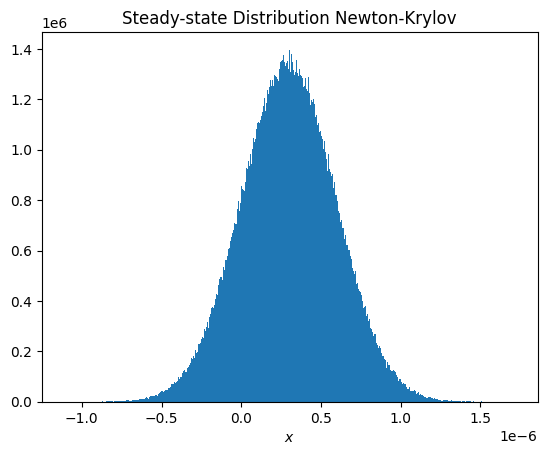

In [74]:
OUSteadyState()